# Exponential

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize

In [3]:
df = pd.read_excel("EnergyResidential_Consumption.xlsx")


df.drop(columns=[
    'Total Energy Consumed by the Commercial Sector (Trillion Btu)',
    'Total Energy Consumed by the Industrial Sector (Trillion Btu)'
], inplace=True)


df.rename(columns={"Total Energy Consumed by the Residential Sector (Trillion Btu)": "Energy Consumed"}, inplace=True)

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
train, test = train_test_split(df, test_size=0.2, shuffle=False)

Slope of the regression line: -3.165202554185631e-16


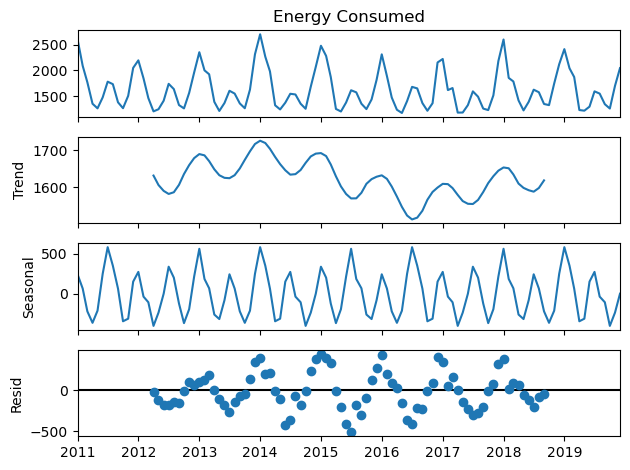

ADF Statistic: -1.899151345254176
p-value: 0.3324604499682673
Critical Values: {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}


In [5]:
X = pd.to_numeric(df.index).values.reshape(-1, 1)
y = df['Energy Consumed'].values
reg = LinearRegression().fit(X, y)
print("Slope of the regression line:", reg.coef_[0])

# Seasonal decomposition
result = seasonal_decompose(df['Energy Consumed'], model='additive', period=30)
result.plot()
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(df['Energy Consumed'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

In [6]:
alpha = 0.5  # Smoothing parameter for level
beta = 0.2   # Smoothing parameter for trend
gamma = 0.1  # Smoothing parameter for seasonality
seasonality_period = 12  
train.index.freq = 'MS'


model = ExponentialSmoothing(train['Energy Consumed'], trend='add', seasonal='add', seasonal_periods=seasonality_period)
fitted_model = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

In [7]:
forecast_horizon = len(test)  
forecast = fitted_model.forecast(forecast_horizon)

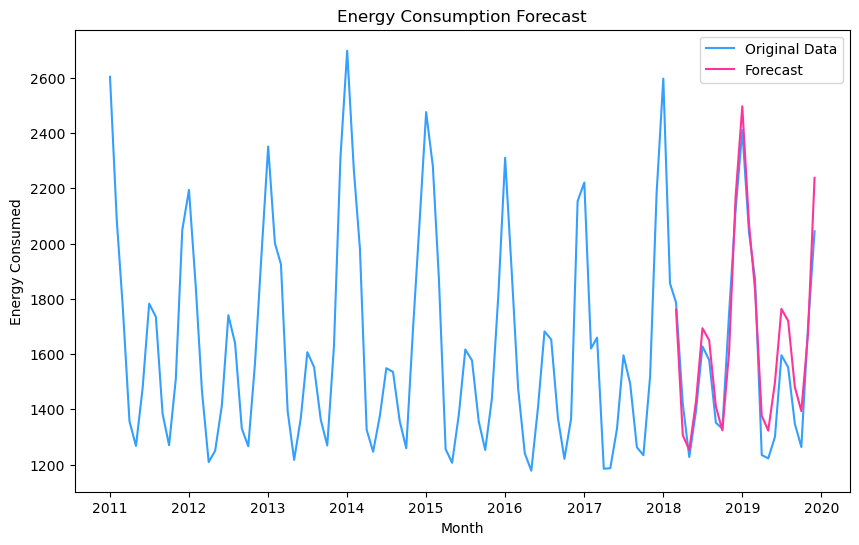

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Energy Consumed'], label='Original Data', color='#339FFF')
plt.plot(test.index, forecast, label='Forecast', color='#FF3399')
plt.title('Energy Consumption Forecast')
plt.xlabel('Month')
plt.ylabel('Energy Consumed')
plt.legend()
plt.show()

In [9]:
mae = mean_absolute_error(test['Energy Consumed'], forecast)
mse = mean_squared_error(test['Energy Consumed'], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['Energy Consumed'] - forecast) / test['Energy Consumed'])) * 100

forecast_df = pd.DataFrame({'Forecast': forecast}, index=test.index)

last_22_df = df.tail(22)  # Select the last 22 values of the original data


mae = mean_absolute_error(last_22_df["Energy Consumed"], forecast_df["Forecast"]) # Mean Absolute Error (MAE)
mse = mean_squared_error(last_22_df["Energy Consumed"], forecast_df["Forecast"]) # Mean Squared Error (MSE)
rmse = np.sqrt(mse) # Root Mean Squared Error (RMSE)
mape = np.mean(np.abs((last_22_df["Energy Consumed"] - forecast_df["Forecast"]) / last_22_df["Energy Consumed"])) * 100 # Mean Absolute Percentage Error (MAPE)


comparison_df = pd.DataFrame({
    'Date': last_22_df.index, 
    'Original Data': last_22_df["Energy Consumed"],
    'Forecasted Data': forecast_df["Forecast"],
})


comparison_df['Absolute Error'] = np.abs(comparison_df['Original Data'] - comparison_df['Forecasted Data'])
comparison_df['Squared Error'] = comparison_df['Absolute Error'] ** 2
comparison_df['MAE'] = mae
comparison_df['MSE'] = mse
comparison_df['RMSE'] = rmse
comparison_df['MAPE'] = mape


comparison_df

,Date,Original Data,Forecasted Data,Absolute Error,Squared Error,MAE,MSE,RMSE,MAPE
Month,,,,,,,,,
2018-03-01,2018-03-01,1786.388,1761.053935,25.334065,641.814859,91.158914,11750.343033,108.398999,6.011887
2018-04-01,2018-04-01,1420.426,1306.789516,113.636484,12913.250545,91.158914,11750.343033,108.398999,6.011887
2018-05-01,2018-05-01,1227.506,1252.801274,25.295274,639.850910,91.158914,11750.343033,108.398999,6.011887
2018-06-01,2018-06-01,1393.576,1427.519037,33.943037,1152.129786,91.158914,11750.343033,108.398999,6.011887
2018-07-01,2018-07-01,1627.884,1693.609890,65.725890,4319.892578,91.158914,11750.343033,108.398999,6.011887
2018-08-01,2018-08-01,1578.690,1649.956513,71.266513,5078.915824,91.158914,11750.343033,108.398999,6.011887
2018-09-01,2018-09-01,1351.772,1410.356064,58.584064,3432.092505,91.158914,11750.343033,108.398999,6.011887
2018-10-01,2018-10-01,1329.709,1323.635676,6.073324,36.885259,91.158914,11750.343033,108.398999,6.011887
2018-11-01,2018-11-01,1746.928,1606.477090,140.450910,19726.458183,91.158914,11750.343033,108.398999,6.011887


# Decomposition

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df2 = pd.read_excel("EnergyResidential_Consumption.xlsx", parse_dates=['Month'], index_col='Month')
train = df2[df2.index < '2019-01-01']
test = df2[df2.index >= '2019-01-01']

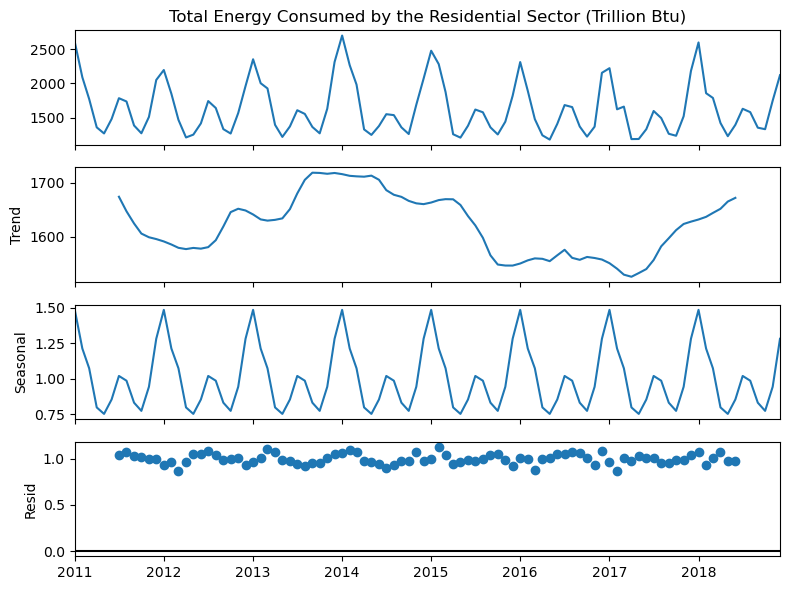

In [12]:
# Decompose the series multiplicatively
result_mul = seasonal_decompose(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'], model='multiplicative')
result_mul.plot().set_size_inches(8, 6)
plt.tight_layout()
plt.savefig('MultiplicativeDecomposition.png')
plt.show()

In [13]:
train_modified = train.copy()
train_modified['trend'] = result_mul.trend
train_modified['seasonal'] = result_mul.seasonal
train_modified['residual'] = result_mul.resid

# Add a column for seasonally adjusted data if you need it
train_modified['seasonal_adj'] = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'] / train_modified['seasonal']

# Display the first 12 rows of the modified training set

excel_filename = "train_modified_data.xlsx"
#train_modified.to_excel(excel_filename)

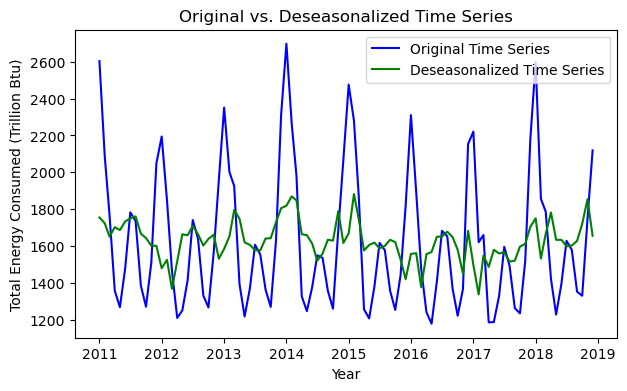

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


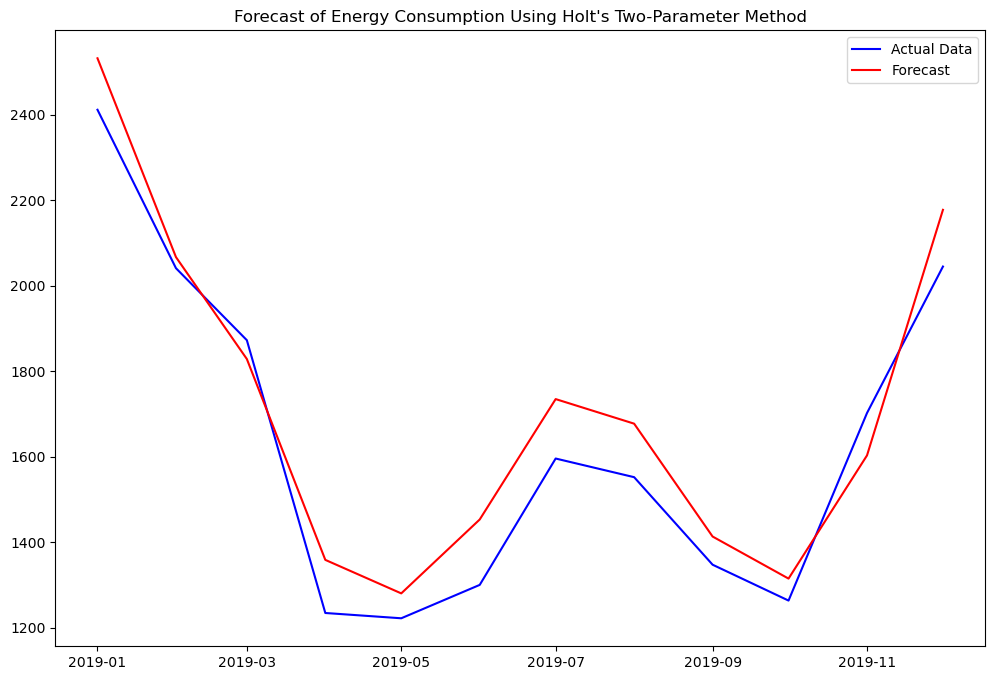

In [14]:
seasonally_adjusted = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'] / result_mul.seasonal
plt.figure(figsize=(7, 4))
plt.plot(train.index, train['Total Energy Consumed by the Residential Sector (Trillion Btu)'], label='Original Time Series', color='blue')
plt.plot(train.index, seasonally_adjusted, label='Deseasonalized Time Series', color='green')
plt.title('Original vs. Deseasonalized Time Series')
plt.xlabel('Year') 
plt.ylabel('Total Energy Consumed (Trillion Btu)')
plt.legend()
plt.savefig("Adjusted data- Multiplicative.png")
plt.show()

model = ExponentialSmoothing(seasonally_adjusted, trend='add', seasonal=None, damped_trend=True, initialization_method="estimated")
fit = model.fit()

# Predict future values and reapply the seasonal component
future_trend = fit.forecast(len(test))
last_seasonal = result_mul.seasonal.iloc[-len(test):]  # Assuming seasonality repeats yearly
forecast = future_trend * last_seasonal.values

# Prepare forecast data for plotting
forecast_series = pd.Series(forecast, index=test.index)

# Plotting the forecast against actual test data
plt.figure(figsize=(12, 8))
plt.plot(test['Total Energy Consumed by the Residential Sector (Trillion Btu)'], label='Actual Data', color='blue')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Forecast of Energy Consumption Using Holt\'s Two-Parameter Method')
plt.legend()

plt.savefig('Forecast Using Holt\'s Two-Parameter Method.png')
plt.show()

multiplicative_decomposition_forecast = pd.Series(forecast, index=test.index)
#multiplicative_decomposition_forecast.to_csv("multiplicative_decomposition_forecast.csv")

In [15]:
comparison_df = pd.DataFrame({
    'Month': test.index.strftime('%B'),
    'Data': test['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
    'Points Estimated': forecast_series,
})

comparison_df['Absolute Error'] = np.abs(comparison_df['Data'] - comparison_df['Points Estimated'])
comparison_df['Squared Error'] = comparison_df['Absolute Error'] ** 2
comparison_df['% Error'] = comparison_df['Absolute Error'] / comparison_df['Data'] * 100

MAPE = comparison_df['% Error'].mean()
RMSE = np.sqrt(comparison_df['Squared Error'].mean())

print(comparison_df.to_string(index=False))
print(f"\nMAPE = {MAPE:.2f}%")
print(f"\nRMSE = {RMSE:.2f}")

    Month     Data  Points Estimated  Absolute Error  Squared Error   % Error
  January 2411.172       2531.529333      120.357333   14485.887644  4.991653
 February 2040.756       2066.689798       25.933798     672.561892  1.270794
    March 1872.455       1828.490865       43.964135    1932.845183  2.347941
    April 1234.695       1358.866390      124.171390   15418.534183 10.056847
      May 1222.334       1280.522662       58.188662    3385.920360  4.760455
     June 1300.385       1453.307994      152.922994   23385.442207 11.759825
     July 1595.800       1734.761334      138.961334   19310.252451  8.707942
   August 1552.212       1677.308171      125.096171   15649.051983  8.059219
September 1347.570       1413.432193       65.862193    4337.828458  4.887478
  October 1263.721       1315.102620       51.381620    2640.070823  4.065899
 November 1702.227       1603.096237       99.130763    9826.908125  5.823592
 December 2044.627       2177.241119      132.614119   17586.504

# STL

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing


df3 = pd.read_excel("EnergyResidential_Consumption.xlsx", parse_dates=['Month'], index_col='Month')
df3['Log Energy Consumption'] = np.log(df3['Total Energy Consumed by the Residential Sector (Trillion Btu)'])


train = df3[df3.index < '2019-01-01']
test = df3[df3.index >= '2019-01-01']

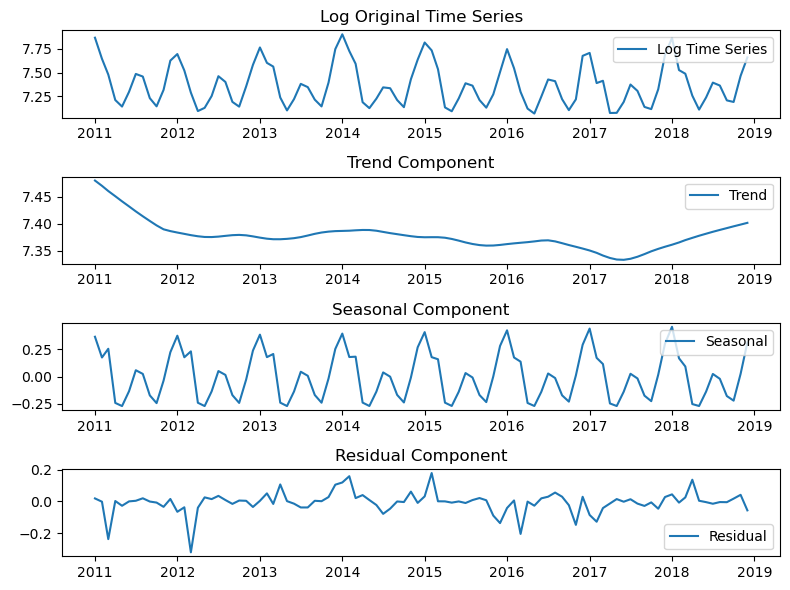

In [18]:
stl = STL(train['Log Energy Consumption'], seasonal=13, robust=True) 
result = stl.fit()


fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(8, 6))
ax0.plot(train.index, train['Log Energy Consumption'], label='Log Time Series')
ax0.set_title('Log Original Time Series')
ax0.legend()

ax1.plot(train.index, result.trend, label='Trend')
ax1.set_title('Trend Component')
ax1.legend()

ax2.plot(train.index, result.seasonal, label='Seasonal')
ax2.set_title('Seasonal Component')
ax2.legend()

ax3.plot(train.index, result.resid, label='Residual')
ax3.set_title('Residual Component')
ax3.legend()

plt.tight_layout()

#plt.savefig("STL log decomposition")
plt.show()

In [19]:
train_modified = train.copy()
train_modified = train.copy()
train_modified['trend'] = result.trend
train_modified['seasonal'] = result.seasonal
train_modified['residual'] = result.resid


train_modified['seasonal_adj'] = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'] / train_modified['seasonal']


# Display the first 12 rows of the modified training set
#excel_filename = "train_modified_dataSTL.xlsx"
#train_modified.to_excel(excel_filename)

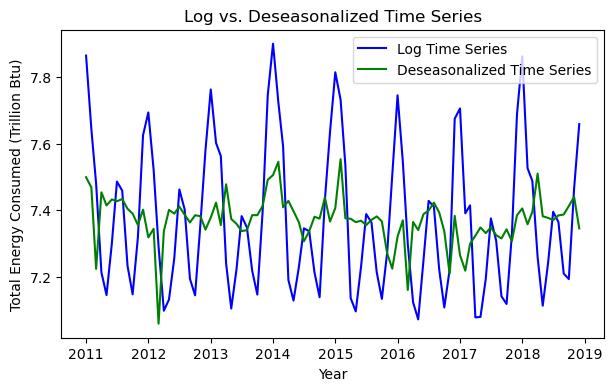

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


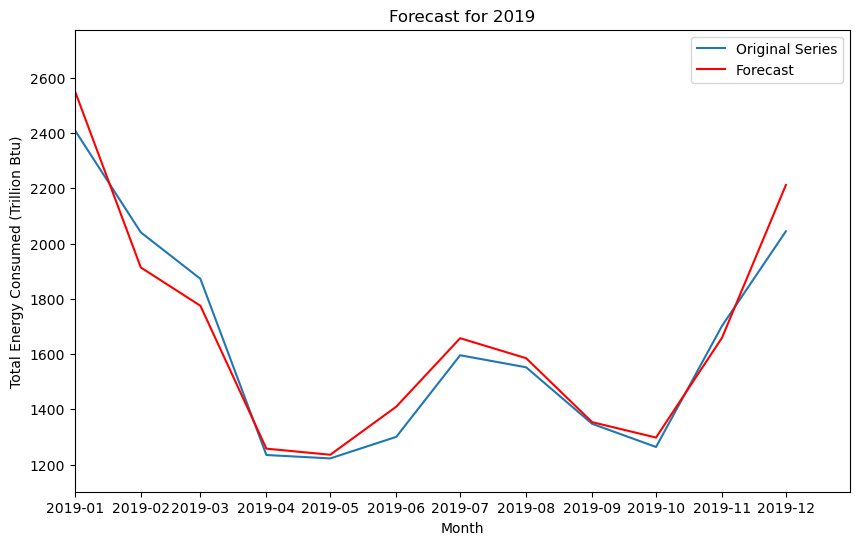

In [20]:
# Deseasonalize the log-transformed training data
deseasonalized_train = train['Log Energy Consumption'] - result.seasonal


plt.figure(figsize=(7, 4))
plt.plot(train.index, train['Log Energy Consumption'], label='Log Time Series', color='blue')
plt.plot(train.index, deseasonalized_train, label='Deseasonalized Time Series', color='green')
plt.title('Log vs. Deseasonalized Time Series')
plt.xlabel('Year') 
plt.ylabel('Total Energy Consumed (Trillion Btu)')
plt.legend()

plt.savefig("STL-Log vs. Deseasonalized Time Series.png")
plt.show()


model = ExponentialSmoothing(deseasonalized_train, trend='add', damped_trend=True, seasonal=None)
fit_model = model.fit()
forecast_deseasonalized = fit_model.forecast(len(test))

# Re-seasonalize the forecast by adding back the seasonal component
seasonal_forecast = np.tile(result.seasonal[-12:], int(np.ceil(len(test) / 12)))[:len(test)]
final_log_forecast = forecast_deseasonalized + seasonal_forecast
# Back-transform the forecast to the original scale
final_forecast = np.exp(final_log_forecast)


plt.figure(figsize=(10, 6))
plt.plot(df.index, df3['Total Energy Consumed by the Residential Sector (Trillion Btu)'], label='Original Series')
plt.plot(test.index, final_forecast, label='Forecast', color='red')
plt.title('Forecast for 2019')
plt.xlabel('Month')
plt.ylabel('Total Energy Consumed (Trillion Btu)')
plt.xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31')])
plt.legend()

#plt.savefig("Forecast STL.png")
plt.show()

stl_forecast = pd.Series(final_forecast, index=test.index)
#stl_forecast.to_csv("2stl_forecast.csv")

In [21]:
actuals = test['Total Energy Consumed by the Residential Sector (Trillion Btu)']
comparison_df = pd.DataFrame({
    'Month': actuals.index.strftime('%B'),
    'Data': actuals,
    'Points Estimated': final_forecast,
})

comparison_df['Absolute Error'] = np.abs(comparison_df['Data'] - comparison_df['Points Estimated'])
comparison_df['Squared Error'] = comparison_df['Absolute Error'] ** 2
comparison_df['% Error'] = comparison_df['Absolute Error'] / comparison_df['Data'] * 100

MAPE = comparison_df['% Error'].mean()
RMSE = np.sqrt(comparison_df['Squared Error'].mean())

print(comparison_df.to_string(index=False))
print(f"\nMAPE = {MAPE:.2f}%")
print(f"\nRMSE = {RMSE:.2f}")

    Month     Data  Points Estimated  Absolute Error  Squared Error  % Error
  January 2411.172       2553.691191      142.519191   20311.719685 5.910785
 February 2040.756       1913.651882      127.104118   16155.456901 6.228286
    March 1872.455       1774.990128       97.464872    9499.401268 5.205192
    April 1234.695       1257.676774       22.981774     528.161930 1.861332
      May 1222.334       1235.573011       13.239011     175.271419 1.083093
     June 1300.385       1409.707588      109.322588   11951.428342 8.406940
     July 1595.800       1657.468045       61.668045    3802.947833 3.864397
   August 1552.212       1585.092629       32.880629    1081.135784 2.118308
September 1347.570       1353.602305        6.032305      36.388699 0.447643
  October 1263.721       1297.853942       34.132942    1165.057709 2.700987
 November 1702.227       1659.256571       42.970429    1846.457803 2.524365
 December 2044.627       2212.098934      167.471934   28046.848785 8.190831

# EDA & SARIMA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# Load the data
df4 = pd.read_excel("Energy_Consumption.xlsx", parse_dates=['Month'], index_col='Month')
df4.drop(columns=[
    'Total Energy Consumed by the Commercial Sector (Trillion Btu)',
    'Total Energy Consumed by the Industrial Sector (Trillion Btu)'
], inplace=True)


#df.rename(columns={"Total Energy Consumed by the Residential Sector (Trillion Btu)": "Energy Consumed"}, inplace=True)

# Split the dataset into train and test sets
train = df4[df4.index < '2019-01-01']
test = df4[df4.index >= '2019-01-01']

Lambda value for Box-Cox transformation: -1.5248795795009484


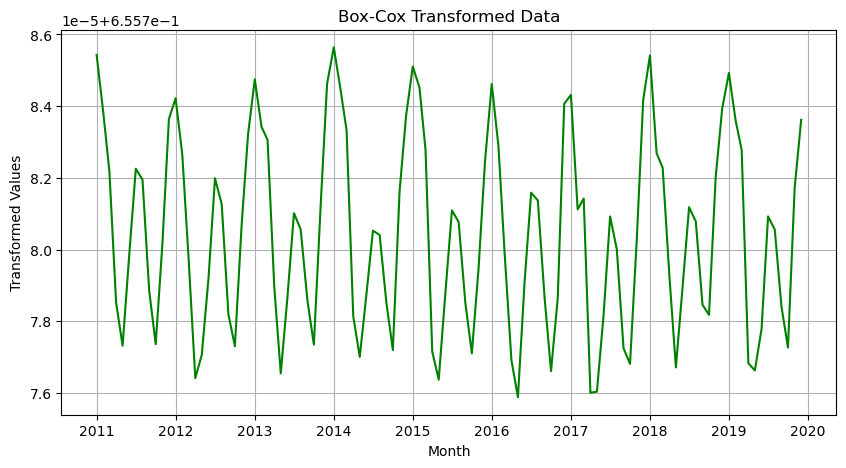

ADF Statistic: -2.0103643693349498
p-value: 0.28204725617728793
The transformed data is not stationary. There may be a need for additional differencing.


In [24]:
# Box-Cox transformation (to stabilise the variance of the time series)
energy_consumption = df4['Total Energy Consumed by the Residential Sector (Trillion Btu)'].values
transformed_data, lambda_value = boxcox(energy_consumption)
print(f"Lambda value for Box-Cox transformation: {lambda_value}")

plt.figure(figsize=(10, 5))
plt.plot(df.index, transformed_data, color='green') 
plt.title('Box-Cox Transformed Data')
plt.xlabel('Month')
plt.ylabel('Transformed Values')
plt.grid(True)
plt.show()

# Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(transformed_data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The transformed data is stationary.")
else:
    print("The transformed data is not stationary. There may be a need for additional differencing.")

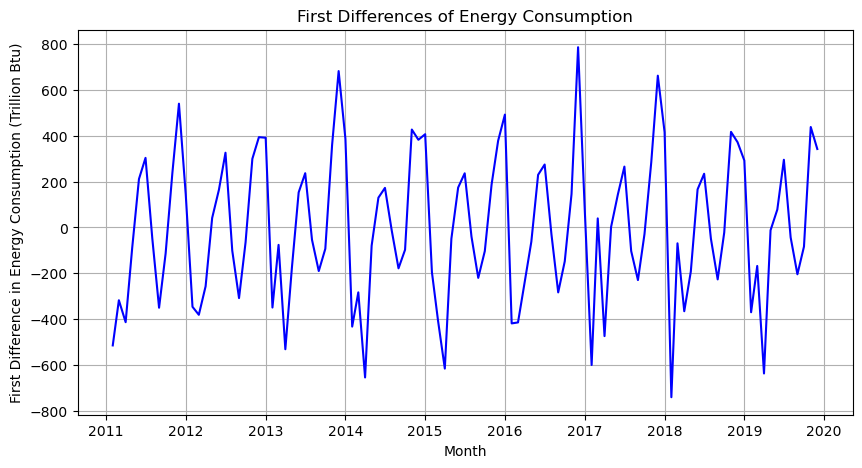

<Figure size 1000x500 with 0 Axes>

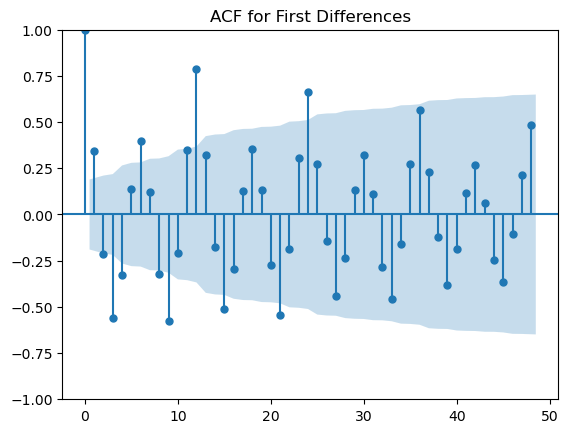

ADF Statistic: -5.182557955487645
p-value: 9.542333163435944e-06
The transformed data is not stationary. There may be a need for additional differencing.


In [25]:
df4['First Difference'] = df4['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff()
df_diff = df4['First Difference'].dropna()  # Drop NaN values created by differencing

plt.figure(figsize=(10, 5))
plt.plot(df_diff.index, df_diff, color='blue')
plt.title('First Differences of Energy Consumption')
plt.xlabel('Month')
plt.ylabel('First Difference in Energy Consumption (Trillion Btu)')
plt.grid(True)
plt.show()

# Autocorrelation Function (ACF) for the first differences
plt.figure(figsize=(10, 5))
plot_acf(df_diff, lags=48)
plt.title('ACF for First Differences')
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(df_diff)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_test[1] < 0.05:
    print("The transformed data is stationary.")
else:
    print("The transformed data is not stationary. There may be a need for additional differencing.")

KPSS Statistic: 0.43941530313542987
p-value: 0.06016581761403886
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
The series is stationary,there is no need for additional differencing.


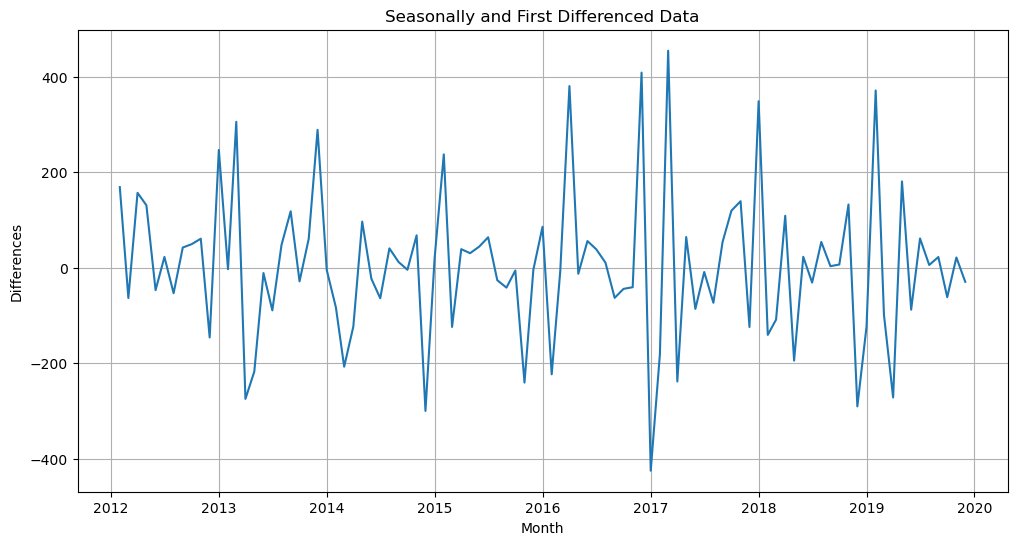

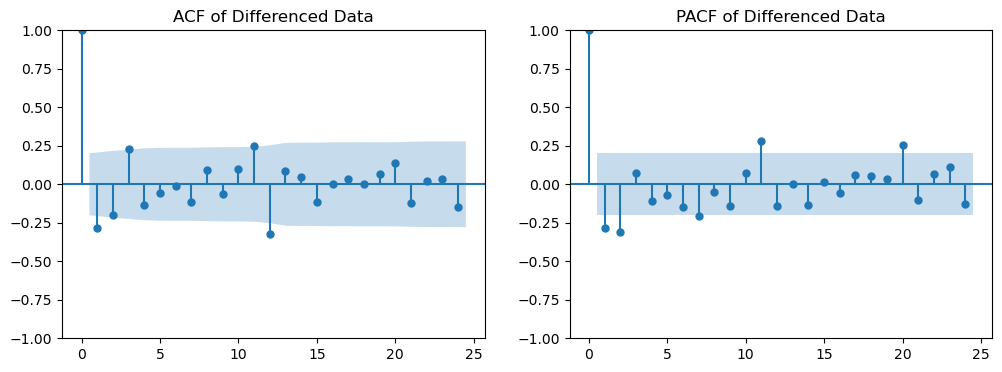

In [26]:
# Seasonal differencing (assuming an annual cycle with monthly data)
df4['Seasonal Difference'] = df4['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff(12)

# First differencing on the seasonally differenced data
df4['Seasonal First Difference'] = df4['Seasonal Difference'].diff()
df_clean = df4.dropna()

# KPSS test to check for stationarity on the seasonally and first differenced data
kpss_result = kpss(df_clean['Seasonal First Difference'], regression='c', nlags='auto')
kpss_stat, p_value, lags, crit_values = kpss_result
print(f"KPSS Statistic: {kpss_stat}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in crit_values.items():
    print(f"  {key} : {value}")

if p_value < 0.05:
    print("The series is not stationary, There may be a need for additional differencing..")
else:
    print("The series is stationary,there is no need for additional differencing.")


plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Seasonal First Difference'], linestyle='-')
plt.title('Seasonally and First Differenced Data')
plt.xlabel('Month')
plt.ylabel('Differences')
plt.grid(True)
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_clean['Seasonal First Difference'], ax=ax[0], lags=24, title="ACF of Differenced Data")
plot_pacf(df_clean['Seasonal First Difference'], ax=ax[1], lags=24, title="PACF of Differenced Data")
plt.show()

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:           Seasonal First Difference   No. Observations:                   95
Model:             SARIMAX(10, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -550.158
Date:                             Mon, 10 Jun 2024   AIC                           1124.316
Time:                                     21:55:16   BIC                           1153.197
Sample:                                 02-01-2012   HQIC                          1135.911
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2709      0.150     -8.491      0.000      -1.564      -0.978
ar.L2         -1.4383      

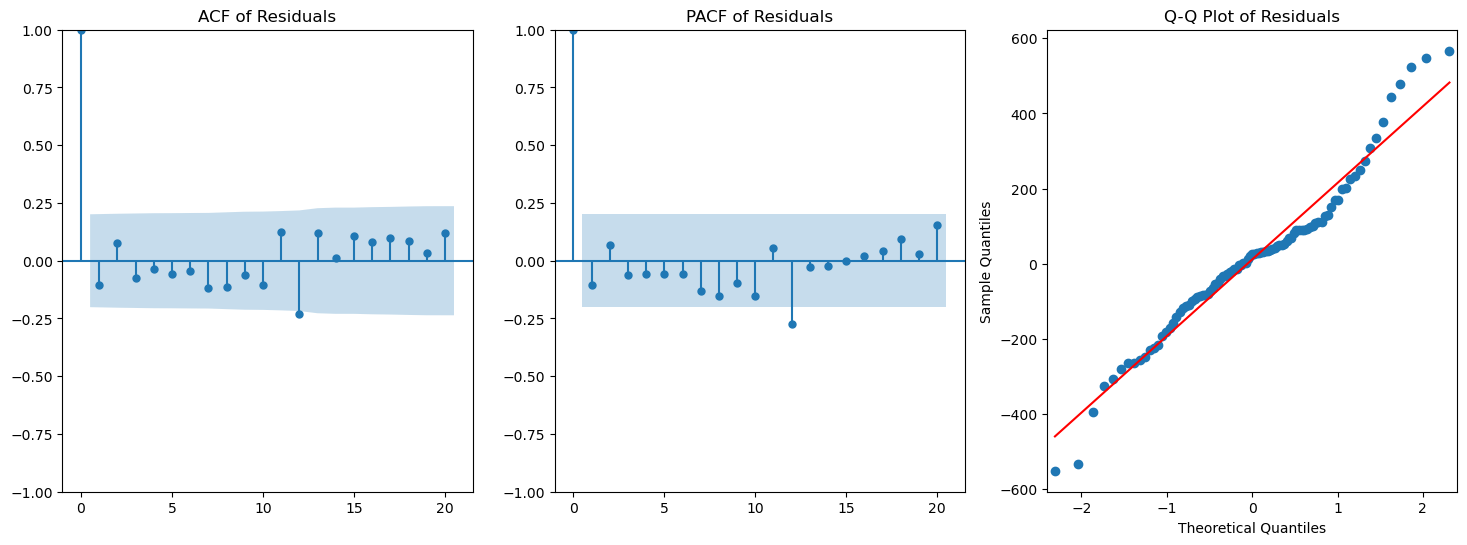

In [27]:
# SARIMA Model
model = SARIMAX(df_clean['Seasonal First Difference'], order=(10, 1, 0), seasonal_order=(1, 1, 0, 12))
results = model.fit(disp=False)
print(results.summary())

# Plot the residuals
residuals = results.resid
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plot_acf(residuals, ax=ax[0])
ax[0].set_title("ACF of Residuals") 
plot_pacf(residuals, ax=ax[1])
ax[1].set_title("PACF of Residuals")  
qqplot(residuals, line='s', ax=ax[2])
ax[2].set_title('Q-Q Plot of Residuals') 
plt.show()

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:           Seasonal First Difference   No. Observations:                   95
Model:             SARIMAX(10, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -550.158
Date:                             Mon, 10 Jun 2024   AIC                           1124.316
Time:                                     21:55:18   BIC                           1153.197
Sample:                                 02-01-2012   HQIC                          1135.911
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2709      0.150     -8.491      0.000      -1.564      -0.978
ar.L2         -1.4383      

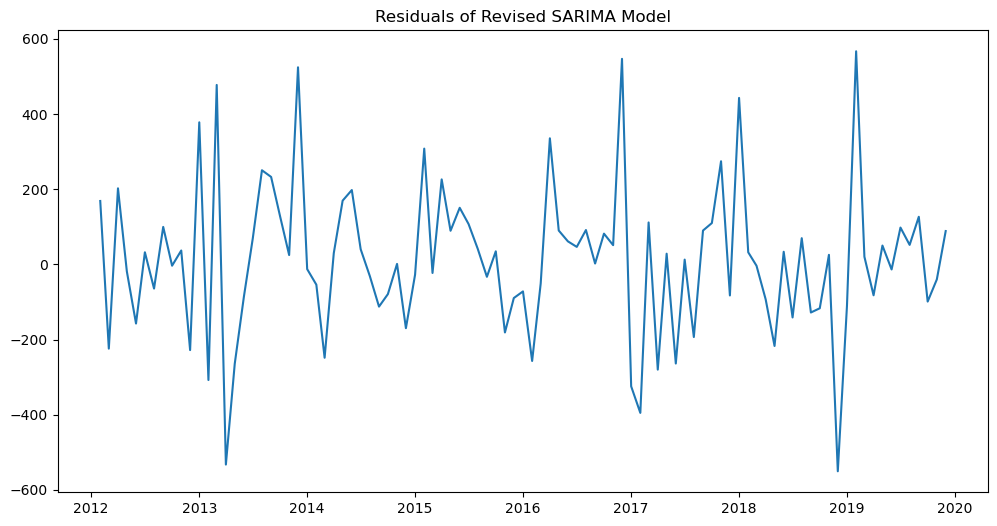

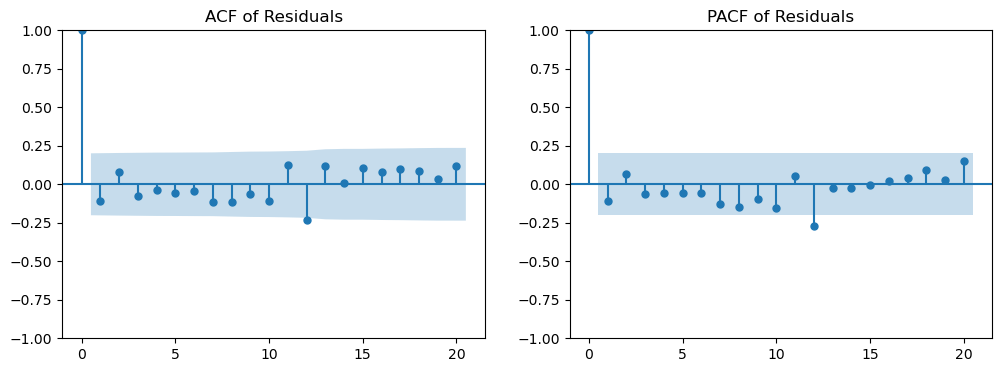

Ljung-Box test results:
     lb_stat  lb_pvalue
10  7.389797   0.688204


In [28]:
model_revised = SARIMAX(df_clean['Seasonal First Difference'],
                        order=(10, 1, 0),
                        seasonal_order=(1, 1, 0, 12))
results_revised = model_revised.fit(disp=False)


print(results_revised.summary())

# Residuals of the revised model
residuals_revised = results_revised.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals_revised)
plt.title('Residuals of Revised SARIMA Model')
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals_revised, ax=ax[0])
ax[0].set_title("ACF of Residuals")
plot_pacf(residuals_revised, ax=ax[1])
ax[1].set_title("PACF of Residuals")
plt.show()

# Ljung-Box test on the revised model residuals
lb_results = acorr_ljungbox(residuals_revised, lags=[10], return_df=True)
print("Ljung-Box test results:")
print(lb_results)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1164.303, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1133.965, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1162.362, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1156.135, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1125.750, Time=0.61 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1128.544, Time=0.53 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1119.341, Time=1.00 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1128.892, Time=0.25 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1120.836, Time=1.02 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                   Differenced Data   No. Observations:                   95
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -553.895
Date:                            Mon, 10 Jun 2024   AIC                           1117.790
Time:                                    21:55:39   BIC                           1129.885
Sample:                                02-01-2012   HQIC                          1122.649
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3320      0.108     -3.069      0.002      -0.544      -0.120
ar.L2         -0.3149      0.095   

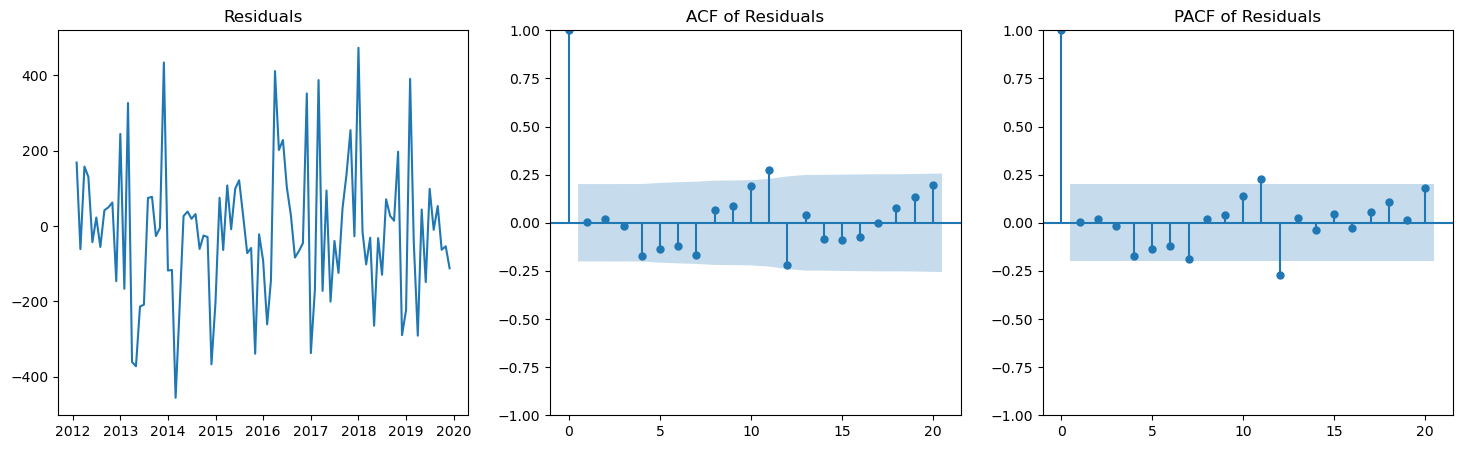

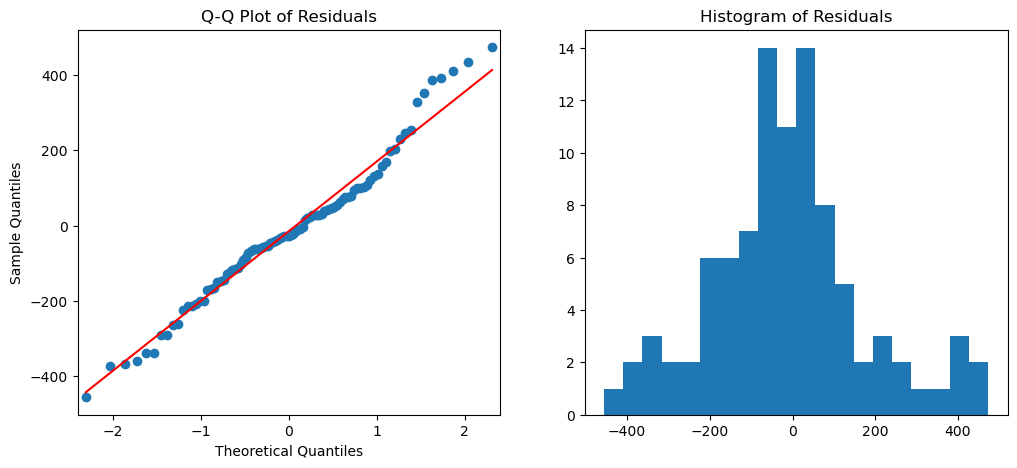

In [29]:
df4['Differenced Data'] = df4['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff(12).diff()
df4 = df4.dropna()

# Using auto_arima to find the best model order
auto_model = auto_arima(df4['Differenced Data'], start_p=0, start_q=0,
                        test='kpss',       # KPSS test to find optimal differencing
                        max_p=10, max_q=10,
                        m=12,              # Seasonal period
                        start_P=0, start_Q=0,
                        seasonal=True,
                        d=None, D=1, trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

# Best SARIMA model
model = SARIMAX(df4['Differenced Data'],
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order)

results = model.fit(disp=False)

# Summary of the model
print(results.summary())

# Residuals
residuals = results.resid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(residuals)
axes[0].set_title('Residuals')
plot_acf(residuals, ax=axes[1])
axes[1].set_title('ACF of Residuals')
plot_pacf(residuals, ax=axes[2])
axes[2].set_title('PACF of Residuals')
plt.show()

# Q-Q plot and standardized residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
qqplot(residuals, line='s', ax=ax[0])
ax[0].set_title('Q-Q Plot of Residuals')
ax[1].hist(residuals, bins=20)
ax[1].set_title('Histogram of Residuals')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=984.476, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=964.003, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=982.479, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=976.253, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=958.903, Time=0.57 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=962.176, Time=0.57 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=949.567, Time=0.85 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=955.624, Time=0.25 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=950.724, Time=

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                    Differenced Data   No. Observations:                   82
Model:             SARIMAX(0, 0, 2)x(2, 1, [], 12)   Log Likelihood                -467.974
Date:                             Mon, 10 Jun 2024   AIC                            945.948
Time:                                     21:56:16   BIC                            957.190
Sample:                                 03-01-2013   HQIC                           950.414
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3619      0.126     -2.861      0.004      -0.610      -0.114
ma.L2         -0.4631      

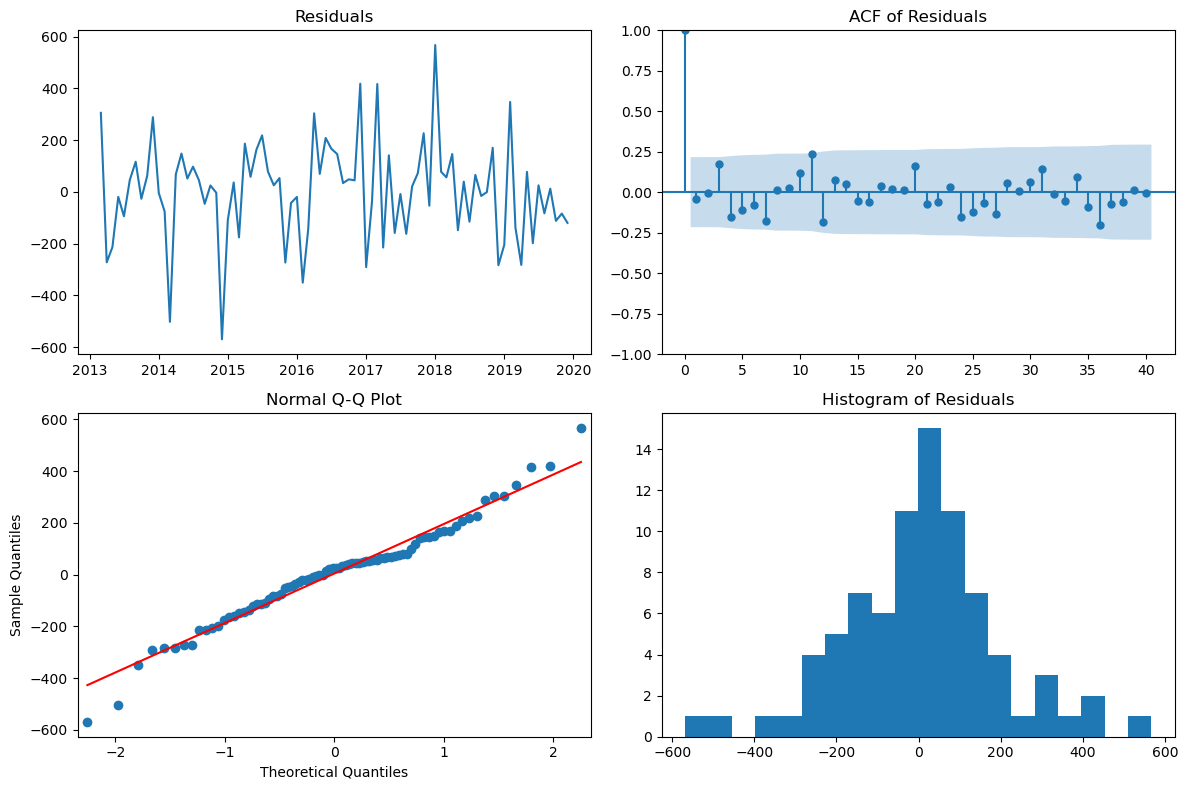

In [30]:
df4['Differenced Data'] = df4['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff(12).diff()
df4.dropna(inplace=True)  

# Using auto_arima to find the best model order
auto_model = auto_arima(df4['Differenced Data'], start_p=1, start_q=1,
                        max_p=3, max_q=3, m=12,
                        start_P=0, start_Q=0, seasonal=True,
                        d=None, D=1, trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

# Best SARIMA model
best_model = SARIMAX(df4['Differenced Data'],
                     order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

# Residuals
residuals = best_model_fit.resid
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(222)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.subplot(223)
qqplot(residuals, line='s', ax=plt.gca())
plt.title('Normal Q-Q Plot')
plt.subplot(224)
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


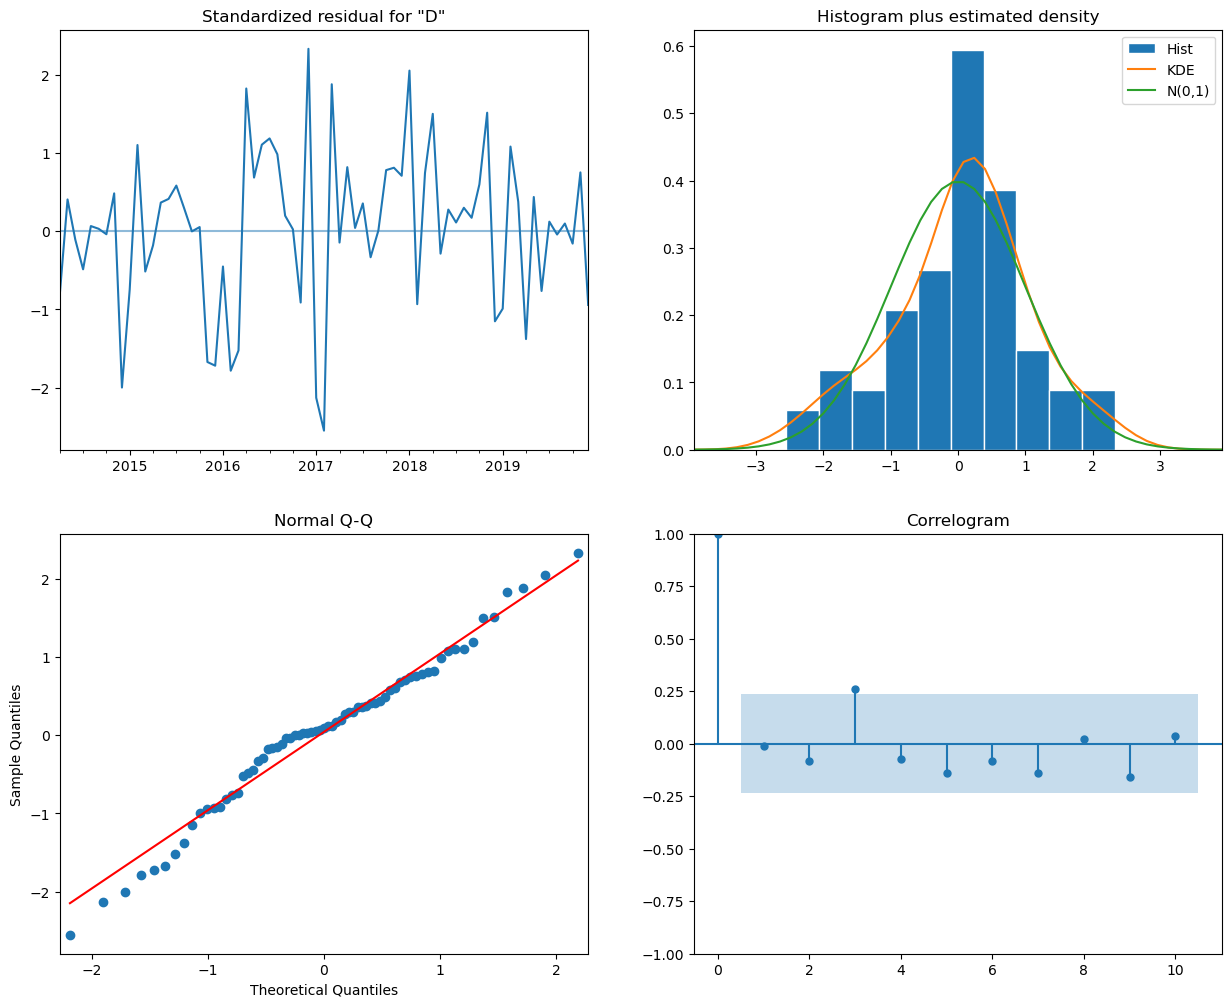

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


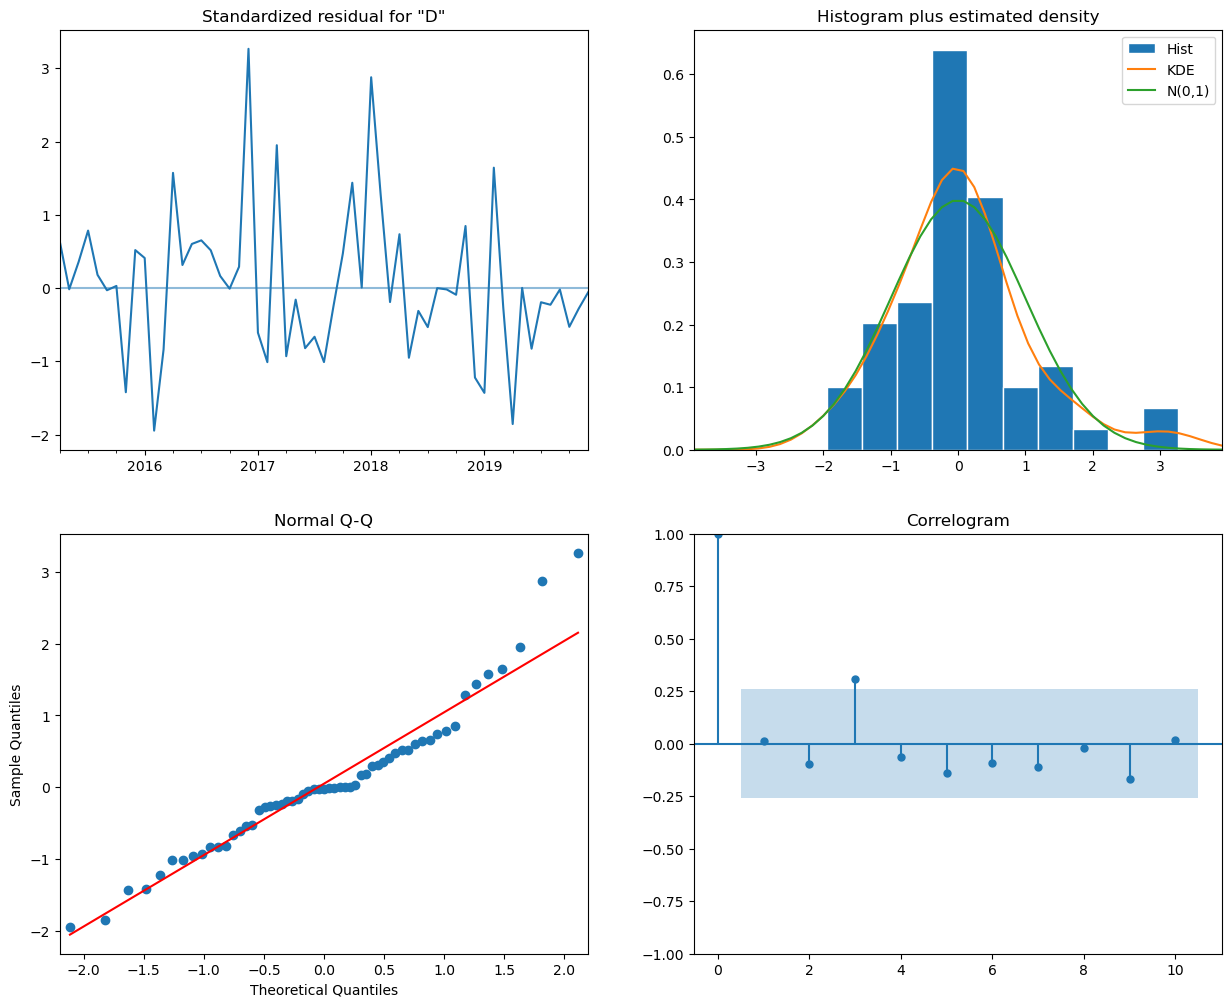

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


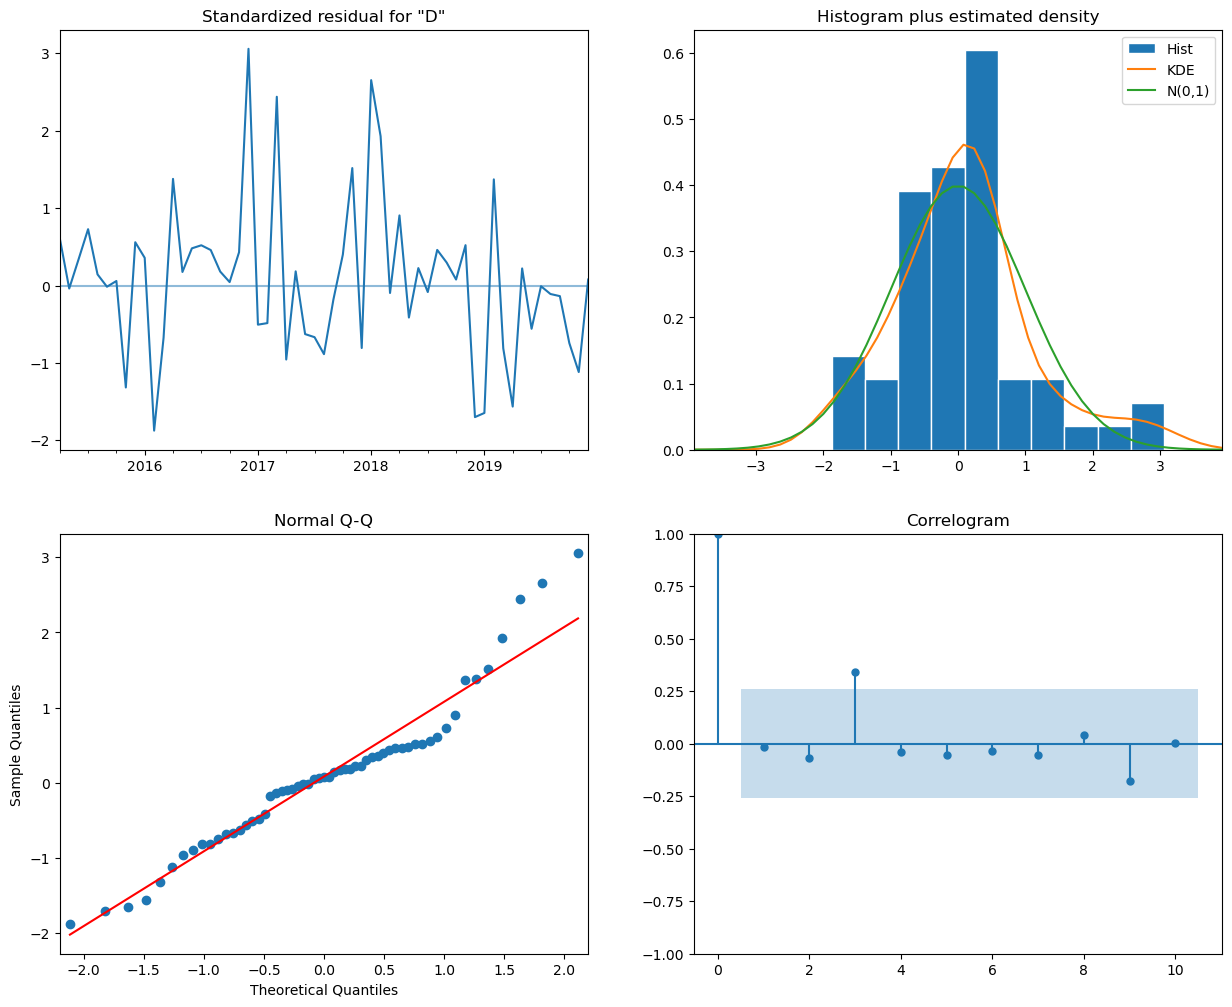

SARIMA(1, 0, 1)(1, 0, 1, 12) AIC: 868.4312826000004
P-values:
 ar.L1       2.429335e-03
ma.L1       8.258853e-25
ar.S.L12    2.961346e-01
ma.S.L12    9.437595e-01
sigma2      9.426448e-01
dtype: float64


SARIMA(1, 0, 1)(0, 1, 1, 12) AIC: 760.7233861493468
P-values:
 ar.L1       2.231887e-01
ma.L1       5.533747e-08
ma.S.L12    5.493837e-12
sigma2      0.000000e+00
dtype: float64


SARIMA(1, 0, 1)(1, 1, 0, 12) AIC: 774.1910858824751
P-values:
 ar.L1       0.013684
ma.L1       0.013587
ar.S.L12    0.000204
sigma2      0.006966
dtype: float64


Best model: SARIMA(1, 0, 1)(0, 1, 1, 12) with AIC: 760.7233861493468


In [31]:
df4['Differenced Data'] = df4['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff(12).diff()
df4.dropna(inplace=True)

# Define a list of SARIMA configurations to try
models = [
    ((1, 0, 1), (1, 0, 1, 12)),
    ((1, 0, 1), (0, 1, 1, 12)),
    ((1, 0, 1), (1, 1, 0, 12))
]

results_summary = []

for params, seasonal_params in models:
    model = SARIMAX(df4['Differenced Data'], order=params, seasonal_order=seasonal_params)
    results = model.fit(disp=False)
    
    results_summary.append({
        'Model': f"SARIMA{params}{seasonal_params}",
        'AIC': results.aic,
        'P-values': results.pvalues
    })

    results.plot_diagnostics(figsize=(15, 12))
    plt.show()


for result in results_summary:
    print(result['Model'], "AIC:", result['AIC'])
    print("P-values:\n", result['P-values'])
    print("\n")


best_model = min(results_summary, key=lambda x: x['AIC'])
print("Best model:", best_model['Model'], "with AIC:", best_model['AIC'])


C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


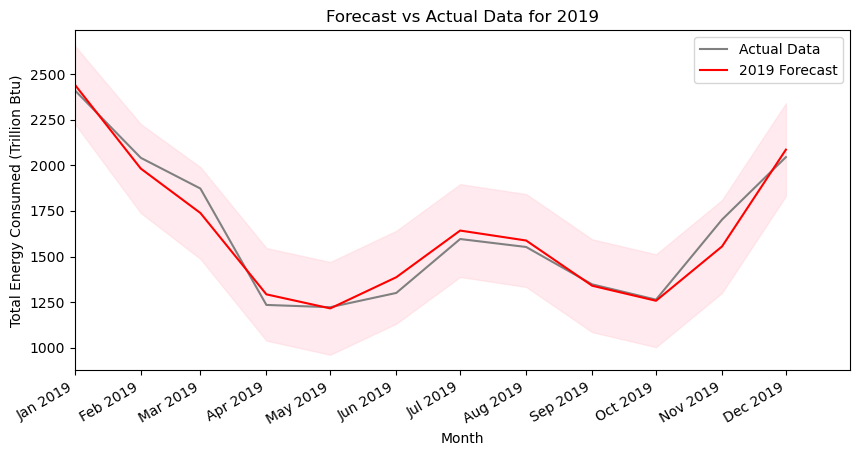

In [32]:
import matplotlib.dates as mdates

# Replace these with your actual best fitting model parameters.
model = SARIMAX(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
                order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12))
results = model.fit(disp=False)


forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

model = SARIMAX(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
                order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12))
results = model.fit(disp=False)


# Plot the actual test data and forecasts for only the year 2019
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Total Energy Consumed by the Residential Sector (Trillion Btu)'], label='Actual Data', color='gray')
plt.plot(forecast_mean.index, forecast_mean, label='2019 Forecast', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)


plt.xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2019-12-31')])


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() 

plt.title('Forecast vs Actual Data for 2019')
plt.xlabel('Month')
plt.ylabel('Total Energy Consumed (Trillion Btu)')
plt.legend()
plt.show()

In [33]:
# Calculate errors and performance metrics
actuals = test['Total Energy Consumed by the Residential Sector (Trillion Btu)']
comparison_df = pd.DataFrame({
    'Month': actuals.index.strftime('%B'),
    'Actual Data': actuals,
    'Forecasted Data': forecast_mean,
})

comparison_df['Absolute Error'] = np.abs(comparison_df['Actual Data'] - comparison_df['Forecasted Data'])
comparison_df['Squared Error'] = comparison_df['Absolute Error'] ** 2
comparison_df['% Error'] = comparison_df['Absolute Error'] / comparison_df['Actual Data'] * 100

MAPE = comparison_df['% Error'].mean()
RMSE = np.sqrt(comparison_df['Squared Error'].mean())

print(comparison_df.to_string(index=False))
print(f"\nMAPE = {MAPE:.2f}%")
print(f"\nRMSE = {RMSE:.2f}")

    Month  Actual Data  Forecasted Data  Absolute Error  Squared Error  % Error
  January     2411.172      2441.683071       30.511071     930.925477 1.265404
 February     2040.756      1981.846074       58.909926    3470.379421 2.886672
    March     1872.455      1738.412304      134.042696   17967.444242 7.158660
    April     1234.695      1292.676082       57.981082    3361.805881 4.695984
      May     1222.334      1215.724848        6.609152      43.680891 0.540699
     June     1300.385      1386.421007       86.036007    7402.194417 6.616195
     July     1595.800      1642.190190       46.390190    2152.049717 2.907018
   August     1552.212      1587.665387       35.453387    1256.942618 2.284056
September     1347.570      1339.970849        7.599151      57.747100 0.563915
  October     1263.721      1257.529960        6.191040      38.328980 0.489906
 November     1702.227      1555.102726      147.124274   21645.552084 8.643047
 December     2044.627      2085.527358 

# Auto Arima Final

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# Load the data
df5 = pd.read_excel("EnergyResidential_Consumption.xlsx", parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train = df5[df5.index < '2019-01-01']
test = df5[df5.index >= '2019-01-01']

Lambda value for Box-Cox transformation: -1.5693386523157564


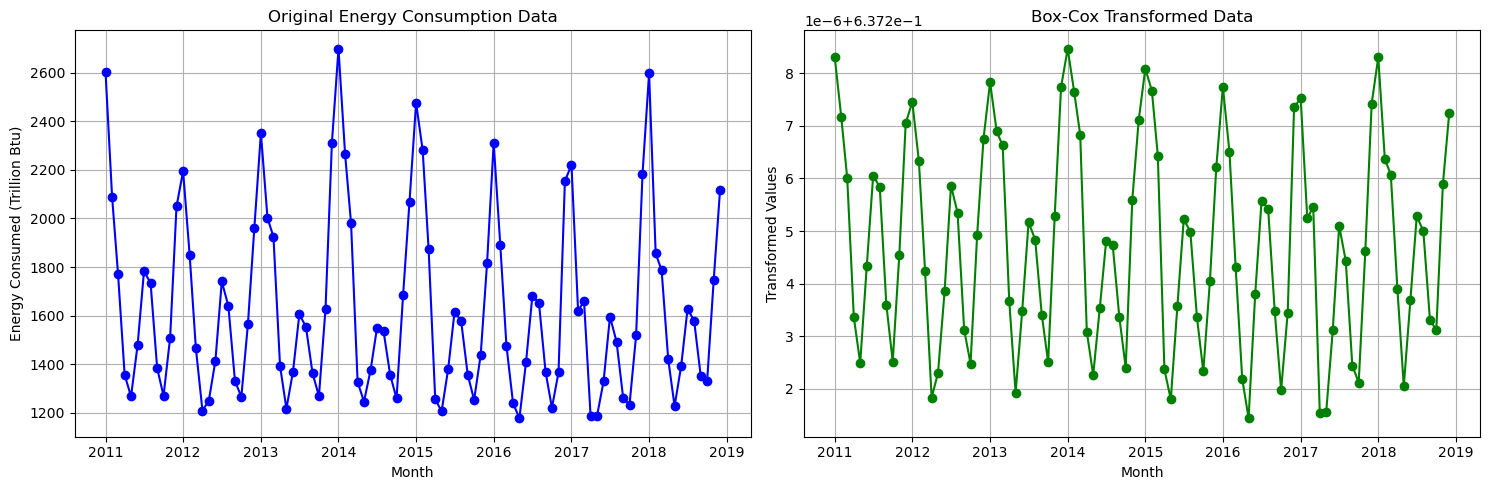

ADF Statistic: -1.6574970182051494
p-value: 0.4531335007782149
The transformed data is not stationary. There may be a need for additional differencing.


In [36]:
# Box-Cox Transformation (to stabilize the variance of the time series)
energy_consumption = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'].values
transformed_data, lambda_value = boxcox(energy_consumption)
print(f"Lambda value for Box-Cox transformation: {lambda_value}")


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Original data
axes[0].plot(train.index, train['Total Energy Consumed by the Residential Sector (Trillion Btu)'], marker='o', color='blue')
axes[0].set_title('Original Energy Consumption Data')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Energy Consumed (Trillion Btu)')
axes[0].grid(True)

# Box-Cox transformed data
axes[1].plot(train.index, transformed_data, marker='o', color='green')
axes[1].set_title('Box-Cox Transformed Data')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Transformed Values')
axes[1].grid(True)

plt.tight_layout()
#plt.savefig("Box-Cox Transformation.png")
plt.show()

# Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(transformed_data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The transformed data is stationary.")
else:
    print("The transformed data is not stationary. There may be a need for additional differencing.")

C:\Users\delga\AppData\Local\Temp\ipykernel_12476\2157277146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['First Difference'] = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff()


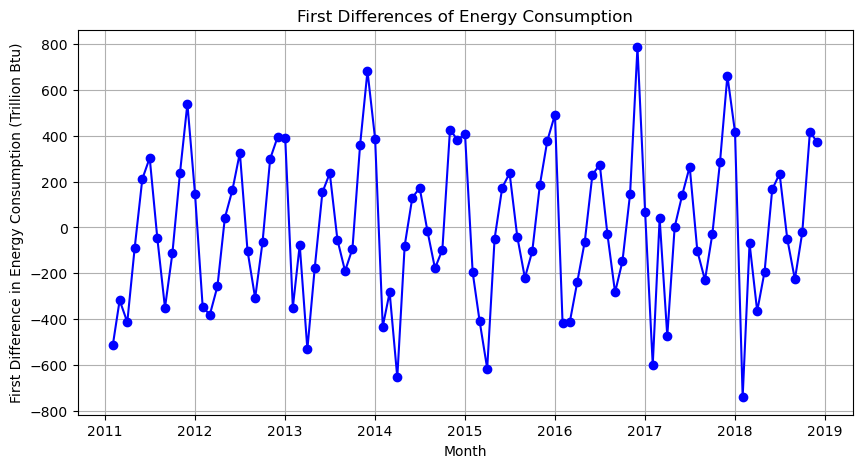

<Figure size 1000x500 with 0 Axes>

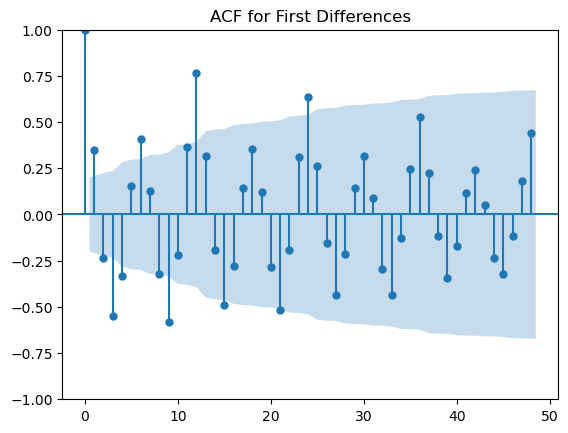

ADF Statistic: -4.655942862321787
p-value: 0.00010173976350100363
The data is stationary.


In [37]:
train['First Difference'] = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff()
train_diff = train['First Difference'].dropna()  # Drop NaN values created by differencing

plt.figure(figsize=(10, 5))
plt.plot(train_diff.index, train_diff, marker='o', color='blue')
plt.title('First Differences of Energy Consumption')
plt.xlabel('Month')
plt.ylabel('First Difference in Energy Consumption (Trillion Btu)')
plt.grid(True)
plt.show()

# Autocorrelation Function (ACF) for the first differences
plt.figure(figsize=(10, 5))
plot_acf(train_diff, lags=48)
plt.title('ACF for First Differences')
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(train_diff)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. There may be a need for additional differencing.")

KPSS Statistic: 0.23328052006803415
p-value: 0.1
Critical Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739
The series is stationary,there is no need for additional differencing.


C:\Users\delga\AppData\Local\Temp\ipykernel_12476\385720325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Seasonal Difference'] = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff(12)
C:\Users\delga\AppData\Local\Temp\ipykernel_12476\385720325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Seasonal First Difference'] = train['Seasonal Difference'].diff()
C:\Users\delga\AppData\Local\Temp\ipykernel_12476\385720325.py:9: InterpolationWarning: The test statis

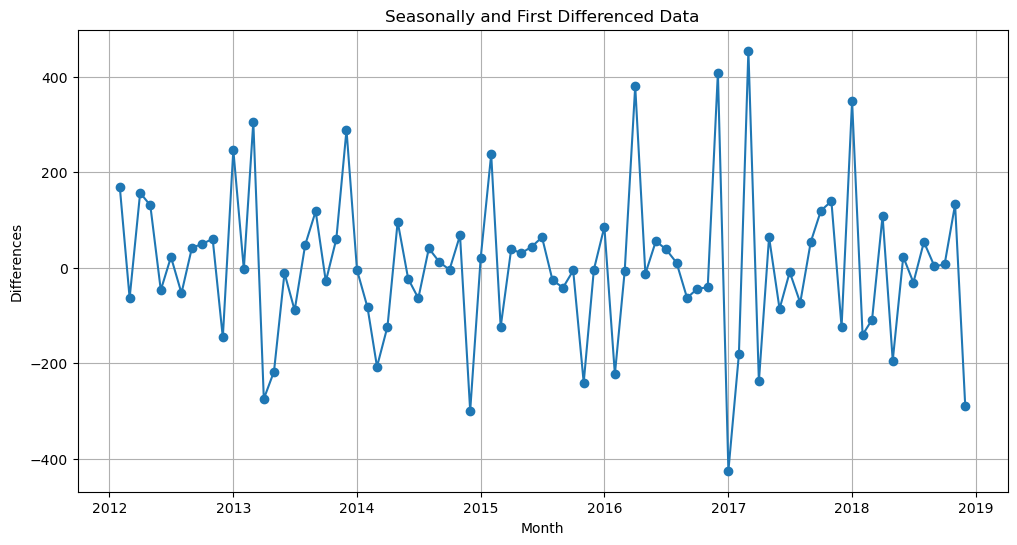

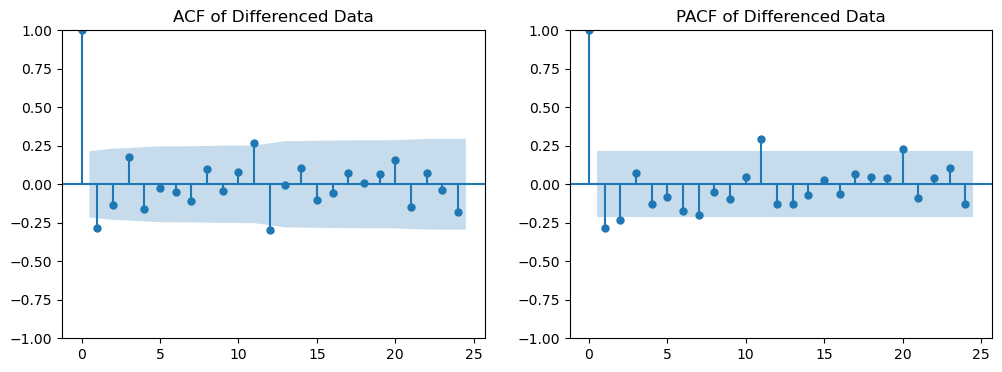

In [38]:
# Seasonal differencing (assuming an annual cycle with monthly data)
train['Seasonal Difference'] = train['Total Energy Consumed by the Residential Sector (Trillion Btu)'].diff(12)

# First differencing on the seasonally differenced data
train['Seasonal First Difference'] = train['Seasonal Difference'].diff()
train_clean = train.dropna()

# KPSS test to check for stationarity on the seasonally and first differenced data
kpss_result = kpss(train_clean['Seasonal First Difference'], regression='c', nlags='auto')
kpss_stat, p_value, lags, crit_values = kpss_result
print(f"KPSS Statistic: {kpss_stat}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in crit_values.items():
    print(f"  {key} : {value}")

if p_value < 0.05:
    print("The series is not stationary, There may be a need for additional differencing..")
else:
    print("The series is stationary,there is no need for additional differencing.")

# Plotting the differenced data
plt.figure(figsize=(12, 6))
plt.plot(train_clean.index, train_clean['Seasonal First Difference'], marker='o', linestyle='-')
plt.title('Seasonally and First Differenced Data')
plt.xlabel('Month')
plt.ylabel('Differences')
plt.grid(True)
plt.show()

# Plot ACF and PACF for the seasonally and first differenced data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_clean['Seasonal First Difference'], ax=ax[0], lags=24, title="ACF of Differenced Data")
plot_pacf(train_clean['Seasonal First Difference'], ax=ax[1], lags=24, title="PACF of Differenced Data")
plt.show()

In [39]:
import matplotlib.dates as mdates
from pmdarima import auto_arima

# Auto_arima to find the best SARIMA parameters
auto_model = auto_arima(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
                        seasonal=True, m=12, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)

print(auto_model.summary())

model = SARIMAX(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
                order=auto_model.order, 
                seasonal_order=auto_model.seasonal_order)

results = model.fit()
print(results.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1100.522, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1069.601, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1098.552, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1075.958, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1057.218, Time=0.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1076.229, Time=0.60 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1059.207, Time=1.33 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1059.198, Time=1.35 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1059.166, Time=0.88 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                                     SARIMAX Results                                                      
Dep. Variable:     Total Energy Consumed by the Residential Sector (Trillion Btu)   No. Observations:                   96
Model:                                             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -523.648
Date:                                                            Mon, 10 Jun 2024   AIC                           1055.296
Time:                                                                    21:56:37   BIC                           1065.019
Sample:                                                                01-01-2011   HQIC                          1059.205
                                                                     - 12-01-2018                                         
Covariance Type:                                                              opg                                         
                

C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\delga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


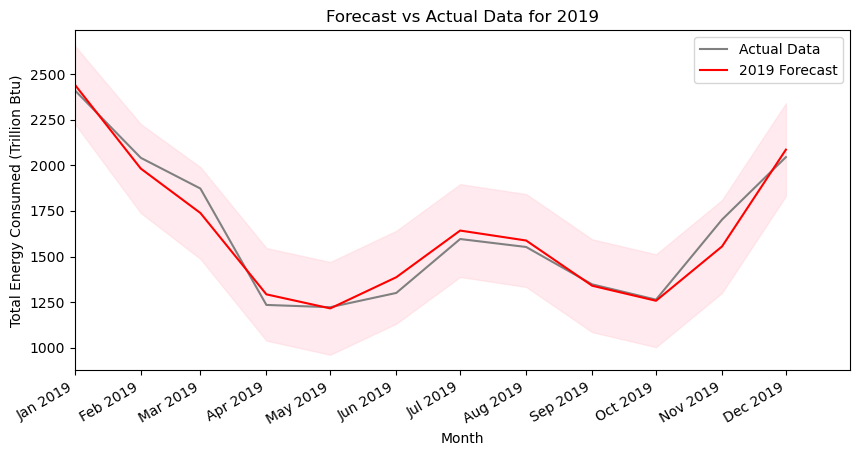

In [40]:
model = SARIMAX(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
                order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12))
results = model.fit(disp=False)


forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

model = SARIMAX(train['Total Energy Consumed by the Residential Sector (Trillion Btu)'],
                order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 12))
results = model.fit(disp=False)



plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Total Energy Consumed by the Residential Sector (Trillion Btu)'], label='Actual Data', color='gray')
plt.plot(forecast_mean.index, forecast_mean, label='2019 Forecast', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2019-12-31')])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  

plt.title('Forecast vs Actual Data for 2019')
plt.xlabel('Month')
plt.ylabel('Total Energy Consumed (Trillion Btu)')
plt.legend()
plt.show()

In [41]:
sarima_forecast_data = pd.DataFrame({
    'Date': forecast_mean.index,
    'Mean': forecast_mean.values,
    'Lower CI': forecast_conf_int.iloc[:, 0].values,
    'Upper CI': forecast_conf_int.iloc[:, 1].values
})


#sarima_forecast_data.to_csv('sarima_forecast_data.csv', index=False)

In [42]:
actuals = test['Total Energy Consumed by the Residential Sector (Trillion Btu)']
comparison_df = pd.DataFrame({
    'Month': actuals.index.strftime('%B'),
    'Actual Data': actuals,
    'Forecasted Data': forecast_mean,
})

comparison_df['Absolute Error'] = np.abs(comparison_df['Actual Data'] - comparison_df['Forecasted Data'])
comparison_df['Squared Error'] = comparison_df['Absolute Error'] ** 2
comparison_df['% Error'] = comparison_df['Absolute Error'] / comparison_df['Actual Data'] * 100

MAPE = comparison_df['% Error'].mean()
RMSE = np.sqrt(comparison_df['Squared Error'].mean())

print(comparison_df.to_string(index=False))
print(f"\nMAPE = {MAPE:.2f}%")
print(f"\nRMSE = {RMSE:.2f}")

    Month  Actual Data  Forecasted Data  Absolute Error  Squared Error  % Error
  January     2411.172      2441.683071       30.511071     930.925477 1.265404
 February     2040.756      1981.846074       58.909926    3470.379421 2.886672
    March     1872.455      1738.412304      134.042696   17967.444242 7.158660
    April     1234.695      1292.676082       57.981082    3361.805881 4.695984
      May     1222.334      1215.724848        6.609152      43.680891 0.540699
     June     1300.385      1386.421007       86.036007    7402.194417 6.616195
     July     1595.800      1642.190190       46.390190    2152.049717 2.907018
   August     1552.212      1587.665387       35.453387    1256.942618 2.284056
September     1347.570      1339.970849        7.599151      57.747100 0.563915
  October     1263.721      1257.529960        6.191040      38.328980 0.489906
 November     1702.227      1555.102726      147.124274   21645.552084 8.643047
 December     2044.627      2085.527358 